In [1]:
import numpy as np
import lbg_forecast.nz as nz
import matplotlib.pyplot as plt
import scipy as sc

In [2]:
"""
run='hpc120g1r1mean'
nruns=5
nzs = []
for i in range(nruns):
    nzs.append(np.load("nz_samples/nz_"+run+"_"+str(i)+".npy", allow_pickle=True))

nzs = np.array(nzs)
nzs = np.vstack(nzs)
print(nzs.shape)
"""

'\nrun=\'hpc120g1r1mean\'\nnruns=5\nnzs = []\nfor i in range(nruns):\n    nzs.append(np.load("nz_samples/nz_"+run+"_"+str(i)+".npy", allow_pickle=True))\n\nnzs = np.array(nzs)\nnzs = np.vstack(nzs)\nprint(nzs.shape)\n'

In [3]:
run='mean_large'
nzs = np.load("nz_samples/nz_"+run+".npy", allow_pickle=True)

print(nzs.shape)

(4, 3)


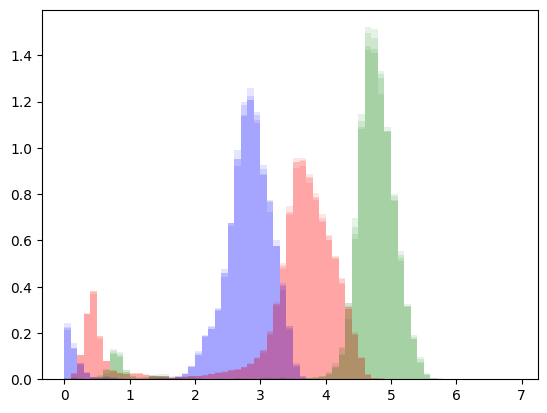

In [4]:
bins = np.arange(0, 7, 0.1)

for n in range(nzs.shape[0]):
    hist = plt.hist(nzs[n][0], density=True, bins=bins, alpha = 0.1, color='blue')
    hist = plt.hist(nzs[n][1], density=True, bins=bins, alpha = 0.1, color='red')
    hist = plt.hist(nzs[n][2], density=True, bins=bins, alpha = 0.1, color='green')

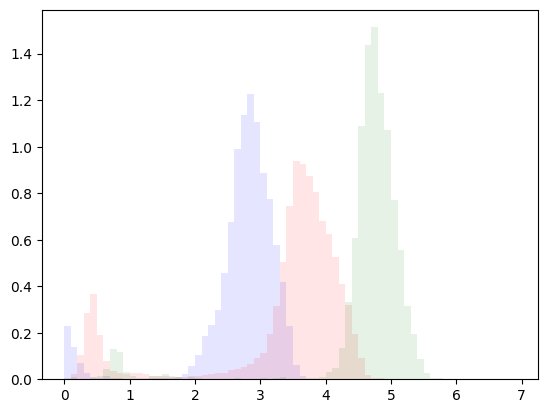

In [5]:
indx=np.random.randint(0, nzs.shape[0])
hist = plt.hist(nzs[indx][0], density=True, bins=bins, alpha = 0.1, color='blue')
hist = plt.hist(nzs[indx][1], density=True, bins=bins, alpha = 0.1, color='red')
hist = plt.hist(nzs[indx][2], density=True, bins=bins, alpha = 0.1, color='green')

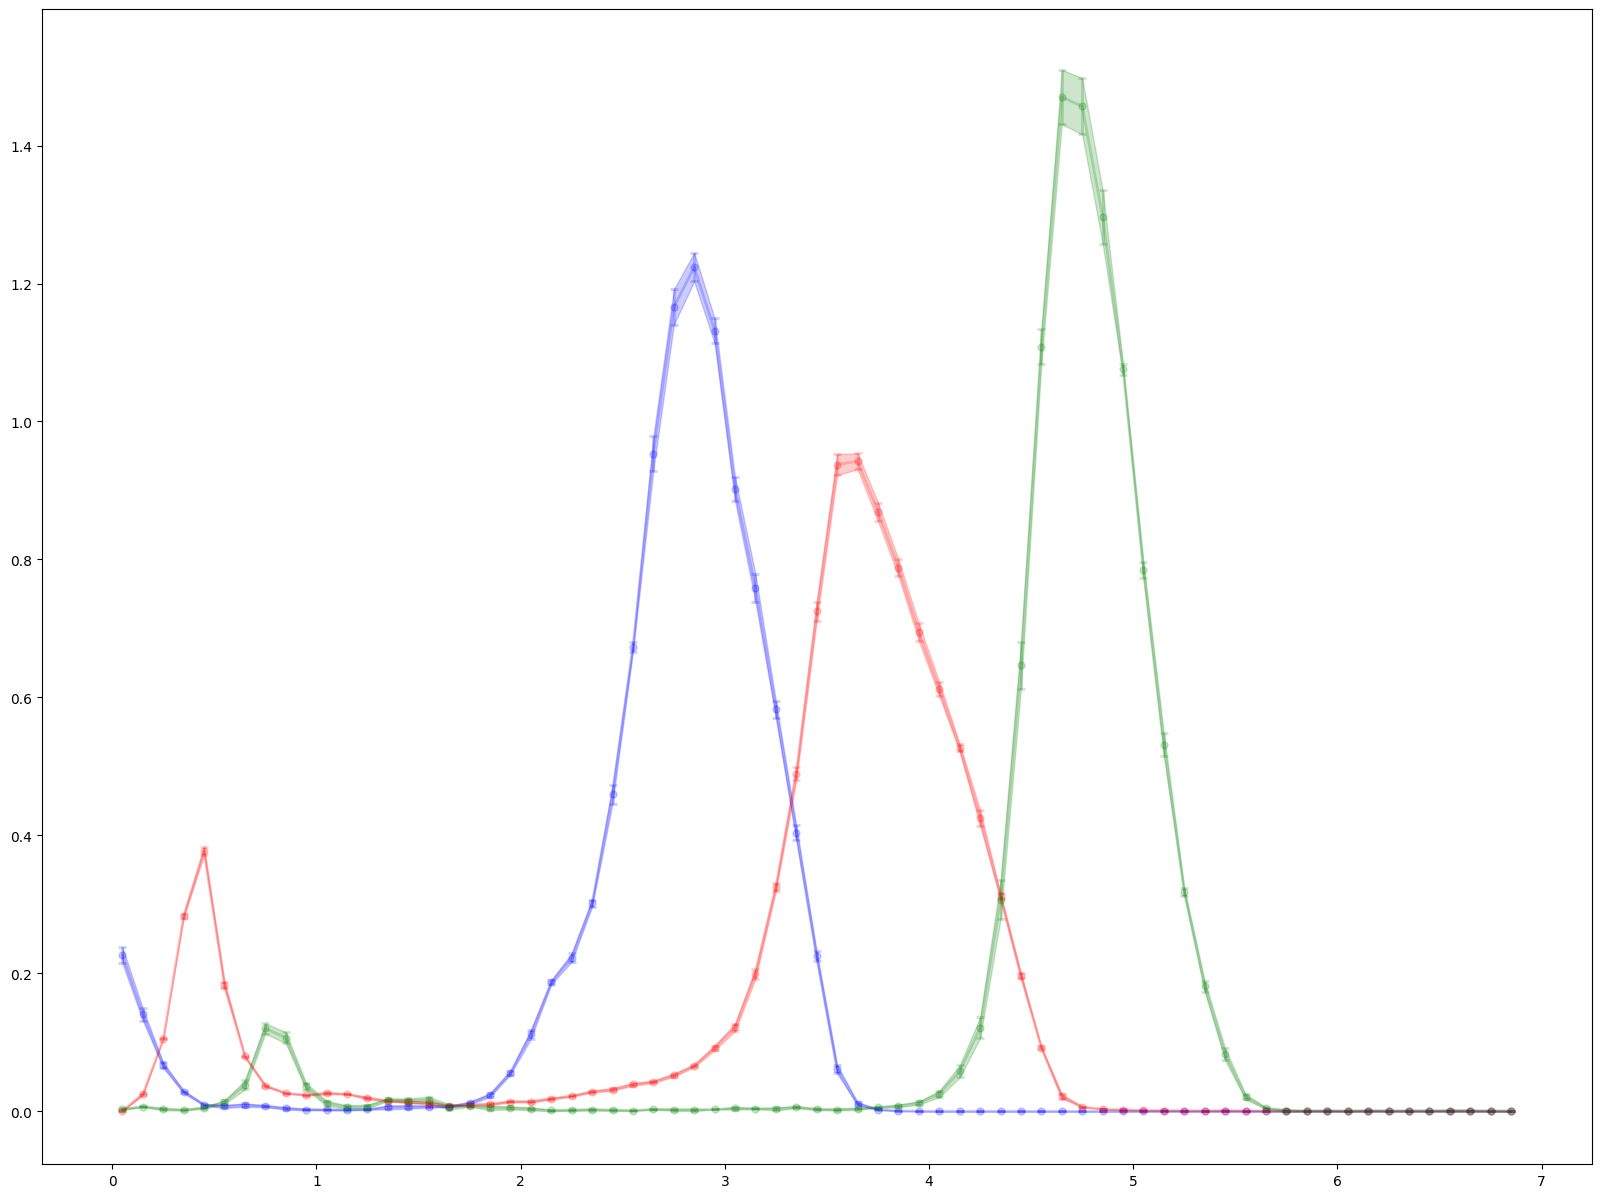

In [6]:
fig1, axes = plt.subplots(1, 1, figsize=(20,15), sharex=False, sharey=False)

colours = ['blue', 'red', 'green']
for drop in range(3):

    values = []
    x = []
    for n in range(nzs.shape[0]):
        hist = axes.hist(nzs[n][drop], density=True, bins=bins, alpha = 0.001, color=colours[drop])
        values.append(hist[0])
        x.append(hist[1])

    values = np.hstack((np.array(values)))
    x = np.array(x)
    x = np.hstack(((x+0.05)[:,:-1]))


    bin_means, bin_edges, binnumber = sc.stats.binned_statistic(x, values, 'mean', bins=bins)
    bin_std, bin_edges, binnumber = sc.stats.binned_statistic(x, values, 'std', bins=bins)
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2

    axes.errorbar(bin_centers, bin_means, bin_std, alpha=0.2, ms=10, marker=".", elinewidth=2, capsize=3, capthick=2, lw=2, color=colours[drop])
    axes.fill_between(bin_centers, bin_means-bin_std, bin_means+bin_std, alpha=0.2, color=colours[drop])

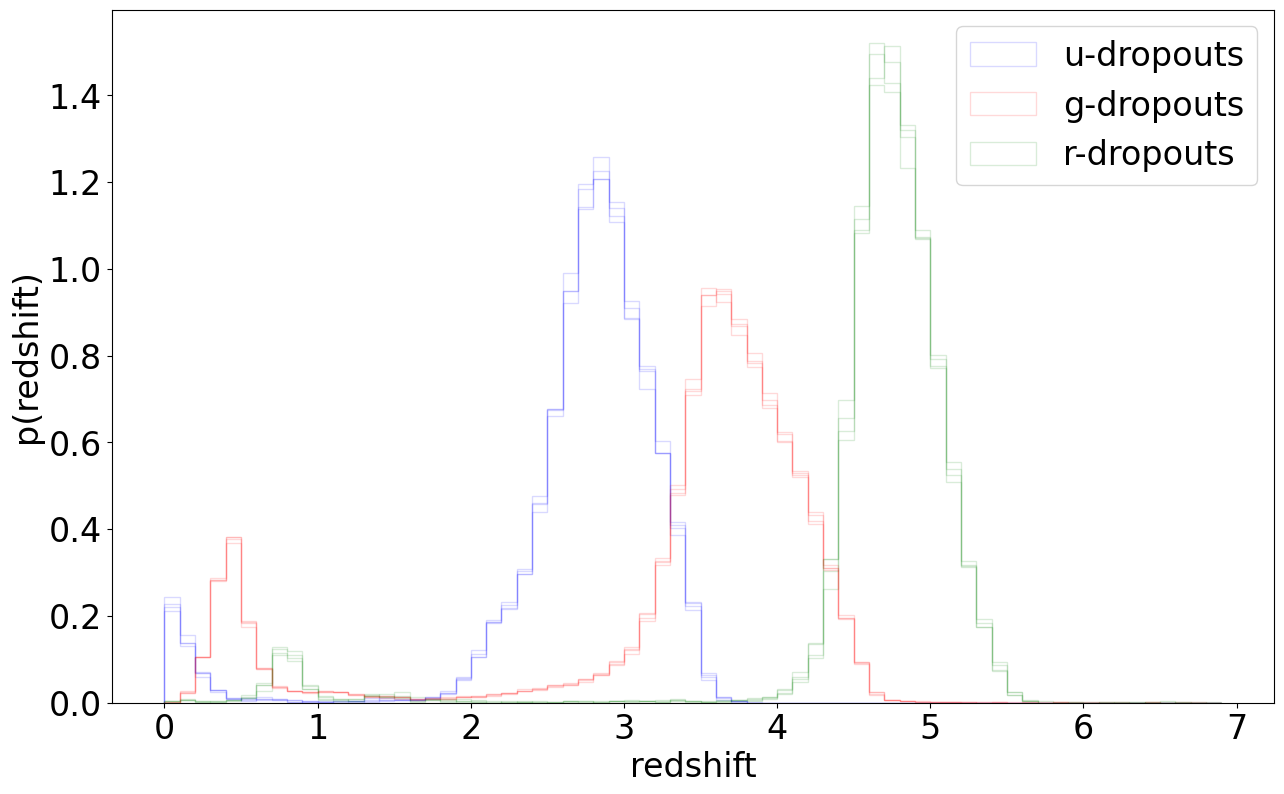

In [7]:
colours = ['blue', 'red', 'green']
labels = ['u-dropouts', "g-dropouts", "r-dropouts"]
ndropouts=3
f, ax = plt.subplots(1, 1, figsize=(15, 9))
for ind in range(nzs.shape[0]):
    for drop in range(ndropouts):
        if(ind == 0):
            hist = plt.hist(nzs[ind][drop], density=True, bins=bins, alpha = 0.15, color=colours[drop], histtype='step', label=labels[drop])
        else:
            hist = plt.hist(nzs[ind][drop], density=True, bins=bins, alpha = 0.15, color=colours[drop], histtype='step')
plt.legend(fontsize=24)
plt.xlabel("redshift", fontsize=24)
plt.ylabel("p(redshift)", fontsize=24)
plt.tick_params('x', labelsize=24)
plt.tick_params('y', labelsize=24)

(0.0, 2.5)

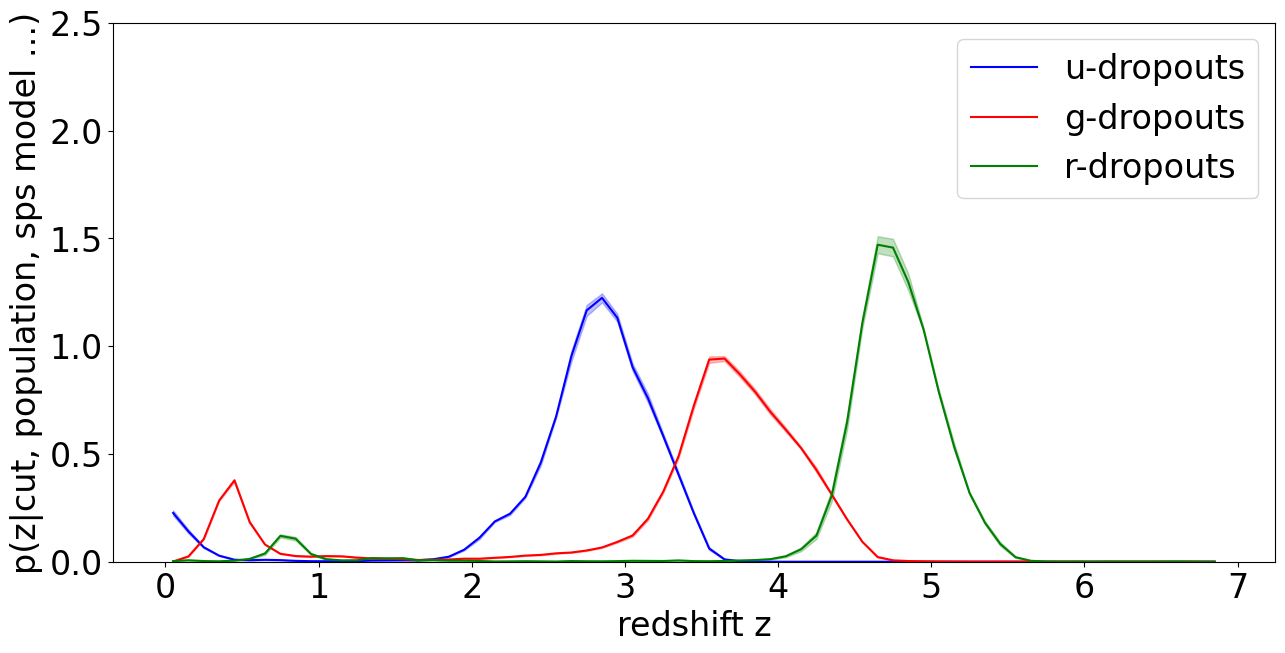

In [8]:
fig1, axes = plt.subplots(1, 1, figsize=(15,7), sharex=False, sharey=False)
for drop in range(ndropouts):

    values = []
    x = []
    for ind in range(nzs.shape[0]):
        hist = axes.hist(nzs[ind][drop], density=True, bins=bins, alpha = 0.001, color=colours[drop])
        values.append(hist[0])
        x.append(hist[1])

    values = np.hstack((np.array(values)))
    x = np.array(x)
    x = np.hstack(((x+0.05)[:,:-1]))


    bin_means, bin_edges, binnumber = sc.stats.binned_statistic(x, values, 'mean', bins=bins)
    bin_std, bin_edges, binnumber = sc.stats.binned_statistic(x, values, 'std', bins=bins)
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2

    #axes.errorbar(bin_centers, bin_means, bin_std, alpha=0.5, ms=10, fmt="o", elinewidth=2, capsize=3, capthick=2, lw=2, color=colours[drop], label=labels[drop])
    axes.fill_between(bin_centers, bin_means-bin_std, bin_means+bin_std, alpha=0.25, color=colours[drop])
    axes.plot(bin_centers, bin_means, color=colours[drop], label=labels[drop])

plt.legend(fontsize=24)
plt.xlabel("redshift z", fontsize=24)
plt.ylabel("p(z|cut, population, sps model ...)", fontsize=24)
plt.tick_params('x', labelsize=24)
plt.tick_params('y', labelsize=24)
plt.ylim(0, 2.5)

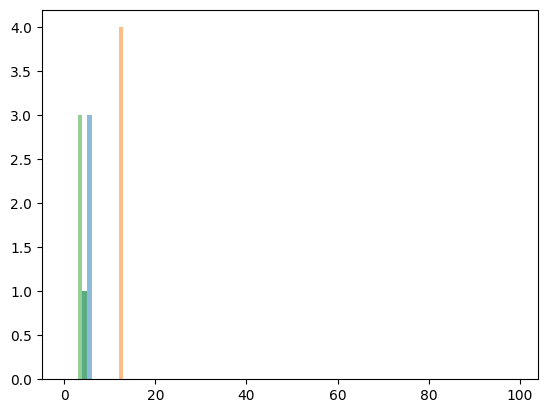

In [9]:
def interlopers(samples):
    nint = len(np.where(samples<1.5)[0])
    ntot = len(samples)
    return (nint/ntot)*100

uints = []
gints = []
rints = []
for n in range(nzs.shape[0]):
    uints.append(interlopers(nzs[n][0]))
    gints.append(interlopers(nzs[n][1]))
    rints.append(interlopers(nzs[n][2]))

nbins = np.arange(0.0, 100, 1)
histogram = plt.hist(uints, alpha=0.5, bins=nbins)
histogram = plt.hist(gints, alpha=0.5, bins=nbins)
histogram = plt.hist(rints, alpha=0.5, bins=nbins)

In [10]:
#np.save("redshifts/emulated_redshifts_0.npy", nzs)